In [1]:
import subprocess
import os
import logging
import re
import itertools
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np

# Define plotting parameters

In [2]:
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define Samples

In [3]:
def runSCC(fileIterator, binSize, maxdist=100000, subsample=0):
    """runs hicreppy scc on a pair of file returned
    by fileIterator for files located in fileDir."""
    # dispatch processes
    processList = []
    for file1, file2 in fileIterator:
        mat1 = f"{file1}::/resolutions/{binSize}"
        mat2 = f"{file2}::/resolutions/{binSize}"
        command = f"hicreppy scc -m {maxdist} -s {subsample} {mat1} {mat2}"
        processList.append((file1, file2, subprocess.Popen(command, stdout=subprocess.PIPE,
                                                           stderr=subprocess.STDOUT, shell=True)))
    # query if processes are finished and store results in list
    resultList = []
    while len(processList) != 0:
        for index, p in enumerate(processList):
            result = p[2].poll()
            if result is not None:
                output, err = p[2].communicate()
                for line in output.decode("UTF-8").split("\n"):
                    logging.info(line)
                    try:
                        value = float(line.strip())
                    except ValueError:
                        pass
                    else:
                        barcode1 = p[0].split("/")[-1].split(".1000.mcool")[0]
                        barcode2 = p[1].split("/")[-1].split(".1000.mcool")[0]
                        resultList.append(
                            {"barcode1": barcode1, "barcode2": barcode2, "sccR": value})
                logging.info("\n\n")
                processList.pop(index)
    return pd.DataFrame(resultList)


# Define HiC sample files

In [4]:
HICDIR1 = "/groups/gerlich/experiments/Experiments_004600/004638/Sequencing_data/Novaseq/cooler/"
HICDIR2 = "/groups/gerlich/experiments/Experiments_004600/004615/Sequencing_data/Novaseq/cooler/"

barcodes = ["CAGATC", "GTTTCG"]

cisFiles = []
transFiles = []
allFiles = []

cisFiles.append(os.path.join(HICDIR1, f"CAGATC.cis.1000.mcool"))
cisFiles.append(os.path.join(HICDIR2, f"GTTTCG.cis.1000.mcool"))
transFiles.append(os.path.join(HICDIR1, f"CAGATC.trans.1000.mcool"))
transFiles.append(os.path.join(HICDIR2, f"GTTTCG.trans.1000.mcool"))
allFiles.append(os.path.join(HICDIR1, f"CAGATC.all.1000.mcool"))
allFiles.append(os.path.join(HICDIR2, f"GTTTCG.all.1000.mcool"))

# Define HiCRep parameters

In [5]:
maxdist = 1000000

# Compare files

In [6]:
allFilesComb = itertools.combinations(allFiles, r=2)
allResultsAll = runSCC(allFilesComb, 100000, maxdist, subsample=0)
allResultsAll.loc[:, "type"] = "all"
allResultsAll.loc[:, "maxdist"] = maxdist

In [7]:
cisFilesComb = itertools.combinations(cisFiles,r=2)
cisResultsAll = runSCC(cisFilesComb, 100000, maxdist, subsample=0)
cisResultsAll.loc[:, "type"] = "cis"
cisResultsAll.loc[:, "maxdist"] = maxdist

In [8]:
transFilesComb = itertools.combinations(transFiles, r=2)
transResultsAll = runSCC(transFilesComb, 100000, maxdist, subsample=0)
transResultsAll.loc[:, "type"] = "trans"
transResultsAll.loc[:, "maxdist"] = maxdist

In [9]:
cisTransFilesComb = itertools.product(cisFiles, transFiles)
cisTransResultsAll = runSCC(cisTransFilesComb, 100000, maxdist, subsample=0)
cisTransResultsAll.loc[:, "type"] = "cis/trans"
cisTransResultsAll.loc[:, "maxdist"] = maxdist

In [10]:
finFrameAll = pd.concat((cisResultsAll, transResultsAll, cisTransResultsAll, allResultsAll))
finFrameAll

,barcode1,barcode2,sccR,type,maxdist
0,CAGATC.cis,GTTTCG.cis,0.924724,cis,1000000.0
0,CAGATC.trans,GTTTCG.trans,0.724991,trans,1000000.0
0,CAGATC.cis,CAGATC.trans,0.380632,cis/trans,1000000.0
1,GTTTCG.cis,CAGATC.trans,0.388040,cis/trans,1000000.0
2,GTTTCG.cis,GTTTCG.trans,0.413817,cis/trans,1000000.0
3,CAGATC.cis,GTTTCG.trans,0.333328,cis/trans,1000000.0
0,CAGATC.all,GTTTCG.all,0.875965,all,1000000.0


## Plot barplot of all, cis and trans only

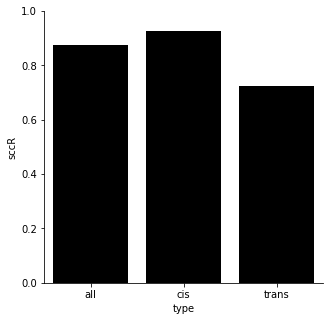

In [13]:
f, ax = plt.subplots()
#sbn.swarmplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", alpha=0.2, order=["all", "cis", "trans", "cis/trans"])
sbn.barplot(x="type", y="sccR", data=finFrameAll, ax=ax, color="black", alpha=1, ci="sd", capsize=0.1, order=["all", "cis", "trans"], errcolor="black")
sbn.despine()
ax.set(ylim=(0,1))
f.set_size_inches(5, 5)
plt.show()

In [14]:
resultsdir = "/groups/gerlich/experiments/Experiments_004700/004727/Results/"
f.savefig(os.path.join(resultsdir, "HiC_Rep_Prom_bar.png"), bbox_inches="tight")
f.savefig(os.path.join(resultsdir, "HiC_Rep_Prom_bar.pdf"), bbox_inches="tight")